In [ ]:
raise

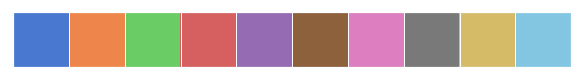

In [1]:
# Initializing

# general purpose
import os
import re
import copy
import glob
import json
import math
import itertools
import functools
import time
import pickle
from pprint import pprint
from datetime import datetime, timedelta, date

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import matplotlib.mlab as mlab
import matplotlib
import seaborn as sns
mpl.rcParams['font.family'] = 'DejaVu Sans'
sns.set(palette='muted')
default_palette = sns.color_palette()
sns.palplot(default_palette)

# display
from pprint import pprint
from IPython.display import display
from tqdm import tqdm_notebook

# stats
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy

PROJECT_DIR = '/home/ubuntu/devbench/main'
def get_path(path_str):
    return os.path.join(PROJECT_DIR, path_str)

In [2]:
from roo_data_storage import snowflake_utils
from roo_data_storage.snowflake_utils import RooSnowflakeAdapter

snowflake_utils.set_logging_for_snowflake_and_botocore('WARNING')

# Connect to snowflake
creds = snowflake_utils.get_snowflake_settings_from_env()

snow = snowflake_utils.RooSnowflakeAdapter(**creds)

def download_file(snow_file_name, dest_dir):
    directory = os.path.join('./', dest_dir)
    try :
        os.makedirs(directory)
    except :
        pass
    _ = snow.download_csv('GET @~/exportcsv/{} file://{}'.format(snow_file_name, directory))
#     _ = snow.download_csv('RM @~/exportcsv/{}/{}'.format(ticket_number, snow_file_name))

    return os.path.join(directory, snow_file_name)

In [3]:
snow_file_name = 'pato_exp_data.csv.gz'
dest_dir = 'data'
sql_path = ('pricing-algorithms-team/pricing_algorithms_utils/order_delivery_fees/sql/' +
            'pato_data.sql')
with open(get_path(sql_path)) as ifile:
    data_store_sql = ifile.read()

data_pull_sql = '''
COPY INTO @~/exportcsv/{}
FROM PATO_EXPERIMENT_ANALYSIS
FILE_FORMAT=(TYPE='CSV' COMPRESSION='gzip' NULL_IF=('') FIELD_OPTIONALLY_ENCLOSED_BY='"')
OVERWRITE=TRUE SINGLE=TRUE HEADER=TRUE
MAX_FILE_SIZE=5000000000
;
'''.format(snow_file_name)

print(data_store_sql)

set (start_date, end_date) = ('2019-05-28', '2019-06-11');

-- Get pato fee components (available for RAs where pato is ACTIVELY generating fees, not just shadow)
CREATE OR REPLACE TEMP TABLE SCRATCH.DELIVEROO.ASSIGNMENT_FEE_COMPONENTS AS (
      WITH base AS (
        SELECT
          calcs.rec:data:pickup_id::INT AS ra_id
          , calcs.rec:data:country_id::INT AS country_id
          , calcs.rec:data:local_currency::STRING AS currency
          , calcs.rec:data:zone_code::STRING AS rider_zone_code
          , calcs.rec:data:zone_id::STRING AS rider_zone_id
          , calcs.rec:message_metadata:source_timestamp AS source_timestamp

          -- Pato settings
          , calcs.rec:data:rider_acceptance_model_enabled::BOOLEAN AS rider_acceptance_model_enabled
          , calcs.rec:data:target_rejection_rate::FLOAT AS target_rejection_rate
          , calcs.rec:data:load_index_one_normalised::FLOAT AS load_index_one_normalised
          , calcs.rec:data:experiment_branch as cohort
 

In [4]:
_ = snow.read_data(data_store_sql)
_ = snow.read_data(data_pull_sql)
raw_data_path = download_file(snow_file_name, dest_dir)
raw_data = pd.read_csv(raw_data_path)
raw_data.columns = raw_data.columns.str.lower()
raw_data.calendar_date = pd.to_datetime(raw_data.calendar_date)
raw_data.ra_created_at = pd.to_datetime(raw_data.ra_created_at)
raw_data.experiment_date = pd.to_datetime(raw_data.experiment_date)

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522127 entries, 0 to 3522126
Data columns (total 24 columns):
ra_id                           int64
stacked                         bool
orders                          int64
cohort                          object
pato_or_param                   object
assignment_rejected             int64
restaurant_id                   int64
rider_zone_id                   float64
rider_zone_code                 object
restaurant_zone_id              int64
restaurant_zone_code            object
city_id                         int64
country_id                      int64
vehicle_type_code               object
ra_created_at                   datetime64[ns]
experiment_date                 object
calendar_date                   datetime64[ns]
rider_experience_time           float64
fee_offered_without_surge       float64
parametric_fee_without_surge    float64
pato_one_hundred_fee            float64
final_fee_offered               float64
target_rejection

In [6]:
raw_data.head()

ra_id  stacked  orders   cohort pato_or_param  assignment_rejected  \
0  286436965    False       1  variant      model_v2                    0   
1  283598691    False       1  control    parametric                    1   
2  287150212    False       1  variant      model_v2                    1   
3  289187745    False       1  control    parametric                    1   
4  281407340     True       2  variant      model_v2                    1   

   restaurant_id  rider_zone_id rider_zone_code  restaurant_zone_id  ...  \
0          26912           23.0             BNC                  23  ...   
1          26912           23.0             BNC                  23  ...   
2          26912           23.0             BNC                  23  ...   
3          26912           23.0             BNC                  23  ...   
4          26912           23.0             BNC                  23  ...   

            ra_created_at  experiment_date  calendar_date  \
0 2019-06-07 08:57:49.329       2019-06-07     2019-06-07   
1 2019-06-02 19:26:05.022       2019-06-02     2019-06-02   
2 2019-06-07 19:53:22.792       2019-06-07     2019-06-07   
3 2019-06-10 14:05:03.354       2019-06-10     2019-06-10   
4 2019-05-30 19:42:12.025       2019-05-30     2019-05-30   

  rider_experience_time fee_offered_without_surge  \
0             14.836300                      4.21   
1             15.313767                      4.31   
2             18.398383                      4.89   
3             14.309450                      4.27   
4             22.169167                      4.28   

  parametric_fee_without_surge pato_one_hundred_fee  final_fee_offered  \
0                         4.26                 4.17               4.21   
1                         4.31                  NaN               4.31   
2                         4.75                 5.04               4.89   
3                         4.27                  NaN               4.27   
4                         4.31                 4.24               4.28   

   target_rejection_rate  cpo_target  
0                 0.6721     3.89405  
1                    NaN     3.89405  
2                 0.6721     3.89405  
3                    NaN     3.89405  
4                 0.6904     3.89405  

[5 rows x 24 columns]

In [60]:
# exclude zones
excluded_zones = pd.read_csv('./data/UK_Zones_Acceptance_based_Incentives.csv', squeeze=True)
excluded_zones

0     WME
1     WGR
2     HAY
3     BWD
4     LEW
5     CNN
6     BAR
7     CPP
8     WOT
9     BRO
10    SID
11    TWI
12    GBC
13    WIG
14    WAL
15    STL
16    SUR
17    STR
18    WEM
19    UPT
20    WAR
21    DER
22    SLO
23    SUA
24    SLS
25    MNS
26     LS
27    BOU
28    SOL
29    PRE
30    DND
31    BKS
32    ECC
33    REI
34    SOS
35    EST
36    ABD
37    POO
38    PET
39    STI
40    HUL
41    HER
42    ABR
43    CRW
44    CLM
45    NGF
46    BAS
47    GRY
48    CHS
49    LIN
50    HEM
Name: rider_zone_code, dtype: object

In [63]:
processed_data = (
    raw_data
    [
        (~raw_data.rider_zone_code.isin(excluded_zones.values))
        & (raw_data.rider_experience_time <= 100)
    ]
    .pipe(lambda df: df.assign(
        eRET_bin=pd.cut(df.rider_experience_time, 8),
#         exp_date=df.apply(lambda row: row.calendar_date if row.ra_created_at.hour >= 4
#                           else row.calendar_date - pd.Timedelta(days=1), axis=1)
    ))
)

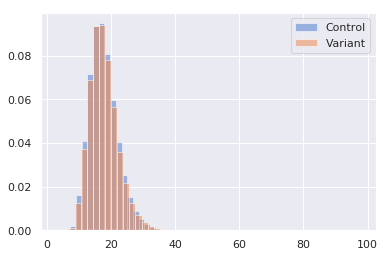

In [65]:
# difference in variant and control eRET observed
tmpdf = processed_data
tmpdf[tmpdf.cohort == 'control'].rider_experience_time.hist(bins=50, alpha=0.5, density=True,
                                                            label='Control')
tmpdf[tmpdf.cohort == 'variant'].rider_experience_time.hist(bins=50, alpha=0.5, density=True,
                                                            label='Variant')
_ = plt.legend()

# CPO

## Difference from Target

In [66]:
# are we hitting or missing our targets

# paired t-test
cpodf = (
    processed_data
    .query('assignment_rejected == 0')
    .groupby(['cohort', 'rider_zone_id', 'vehicle_type_code', 'experiment_date'])
    .agg({'fee_offered_without_surge': 'sum', 'orders': 'sum', 'cpo_target': 'mean'})
    .reset_index()
    
    # sum over all fees in a zone and divide by total orders orders to get observed_cpo
    .pipe(lambda df: df.assign(
        observed_cpo=(df.fee_offered_without_surge / df.orders),
        target_err=df.cpo_target - (df.fee_offered_without_surge / df.orders),
        dow=df.experiment_date.dt.day_name()
    ))
)

# avg of averages
tmpdf = cpodf.groupby(['cohort', 'rider_zone_id', 'vehicle_type_code']).mean().reset_index()

print('Zone Vehicle Level Target Error\n')
print('control : {:.3f}'.format(tmpdf.query('cohort == "control"').target_err.mean()))
print('variant : {:.3f}'.format(tmpdf.query('cohort == "variant"').target_err.mean()))

display(tmpdf.groupby('cohort').mean().drop('rider_zone_id', axis=1))

print('\n\nZone Vehicle Level Weighted Target Error\n')
tmpdf = (
    pd.merge(
        (
            cpodf
            .groupby('cohort')
            .apply(
                lambda df: (df.observed_cpo * df.orders).div(df.orders.sum()).sum()
            )
            .to_frame('weighted_observed_cpo')
        ),
        (
            cpodf
            .groupby('cohort')
            .apply(
                lambda df: (df.cpo_target * df.orders).div(df.orders.sum()).sum()
            )
            .to_frame('weighted_target_cpo')
        ),
        left_index=True, right_index=True
    ).pipe(lambda df: df.assign(target_err=df.weighted_target_cpo - df.weighted_observed_cpo))
)
display(tmpdf.target_err)
display(tmpdf)

Zone Vehicle Level Target Error

control : 0.015
variant : 0.036


fee_offered_without_surge      orders  cpo_target  observed_cpo  \
cohort                                                                     
control                 883.292654  232.012601    4.158740      4.143341   
variant                 871.521984  232.437314    4.154447      4.118879   

         target_err  
cohort               
control    0.015399  
variant    0.035568



Zone Vehicle Level Weighted Target Error



cohort
control   -0.002311
variant    0.053657
Name: target_err, dtype: float64

weighted_observed_cpo  weighted_target_cpo  target_err
cohort                                                         
control               3.805567             3.803256   -0.002311
variant               3.748110             3.801767    0.053657

Observed PATO Mean CPO : 4.097
Target Mean CPO : 4.126
Significance : 0.00403


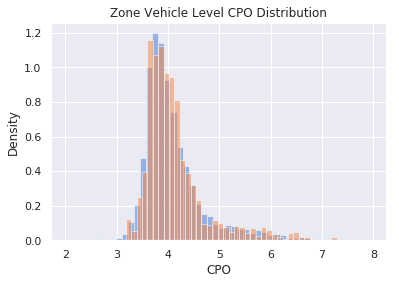

In [67]:
cpodf.observed_cpo.hist(bins=50, alpha=0.5, density=True, label='Observed PATO')
cpodf.cpo_target.hist(bins=50, alpha=0.5, density=True, label='Target')
plt.xlabel('CPO')
plt.ylabel('Density')
plt.title('Zone Vehicle Level CPO Distribution')
print('Observed PATO Mean CPO : {:.3f}'.format(cpodf.observed_cpo.mean()))
print('Target Mean CPO : {:.3f}'.format(cpodf.cpo_target.mean()))
print('Significance : {:.5f}'.format(
    stats.ttest_ind(cpodf.observed_cpo, cpodf.cpo_target, nan_policy='omit').pvalue
))

## Significane of Test Difference

Zone Vehicle level paired differences mean : -0.032
Significance : 0.00000


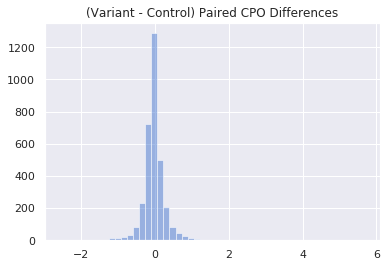

In [97]:
tmpdf = (
    cpodf
    
    # remove all zones with a single day of data (no paired observations)
    .pipe(lambda df: df.groupby(['rider_zone_id', 'vehicle_type_code', 'dow']).filter(
        lambda zvdf: len(zvdf) > 1
    ))
    
    # calculating paired differences
    .groupby(['rider_zone_id', 'vehicle_type_code', 'dow'])
    .apply(lambda df: (df[df.cohort == 'variant'].observed_cpo.values[0]
                       - df[df.cohort == 'control'].observed_cpo.values[0])
          )
)

tmpdf.hist(bins=50, alpha=0.5)
plt.title('(Variant - Control) Paired CPO Differences')
print('Zone Vehicle level paired differences mean : {:.3f}'.format(tmpdf.mean()))
print('Significance : {:.5f}'.format(stats.ttest_1samp(tmpdf.values, 0).pvalue))

# Acceptance Rate

Zone level paired differences mean : -0.001
Significance : 0.84548


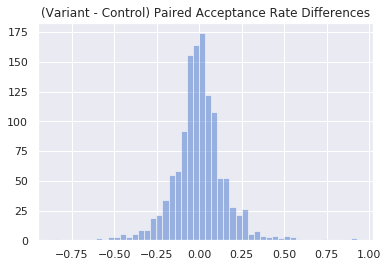

In [98]:
# Using Zone day level values since that is the level of randomization
tmpdf = (
    processed_data
    .groupby(['cohort', 'rider_zone_id', 'experiment_date'])
    .assignment_rejected.mean()
    .apply(lambda x: 1 - x)
    .reset_index()
    .rename(columns={'assignment_rejected': 'acceptance_rate'})
    .pipe(lambda df: df.assign(
        dow=df.experiment_date.dt.day_name()
    ))
    
    # remove all zones with a single day of data (no paired observations)
    .pipe(lambda df: df.groupby(['rider_zone_id', 'dow']).filter(
        lambda zvdf: len(zvdf) > 1
    ))
    
    # calculating paired differences
    .groupby(['rider_zone_id', 'dow'])
    .apply(lambda df: (df[df.cohort == 'variant'].acceptance_rate.values[0]
                       - df[df.cohort == 'control'].acceptance_rate.values[0])
          )
)
tmpdf.hist(bins=50, alpha=0.5)
plt.title('(Variant - Control) Paired Acceptance Rate Differences')
print('Zone level paired differences mean : {:.3f}'.format(tmpdf.mean()))
print('Significance : {:.5f}'.format(stats.ttest_1samp(tmpdf.values, 0).pvalue))

# Fee Offered by Distance

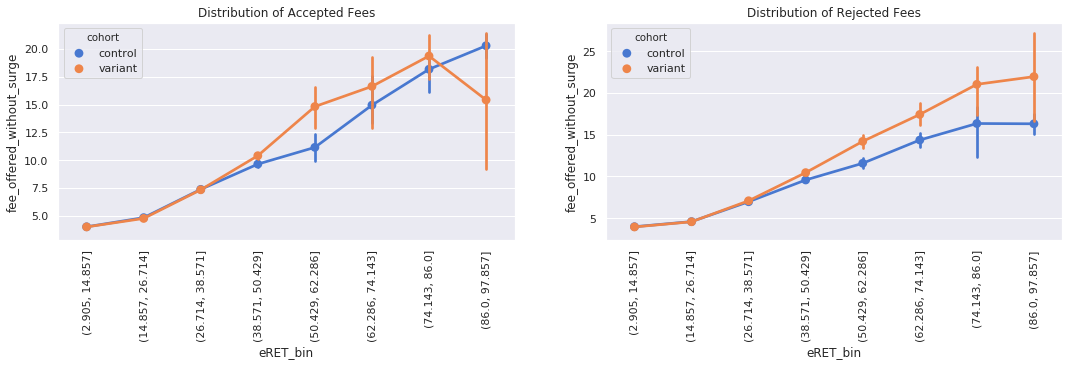

In [77]:
# difference in variant and control fee curves
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

tmpdf = (
    processed_data
    .query('assignment_rejected == 0')
    .groupby(['cohort', 'rider_zone_id', 'experiment_date', 'eRET_bin'])
    .fee_offered_without_surge.mean()
    .reset_index()
)
sns.pointplot(x='eRET_bin', y='fee_offered_without_surge', hue='cohort',
              data=tmpdf, ax=ax[0], alpha=0.5)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('Distribution of Accepted Fees')

tmpdf = (
    processed_data
    .query('assignment_rejected == 1')
    .groupby(['cohort', 'rider_zone_id', 'experiment_date', 'eRET_bin'])
    .fee_offered_without_surge.mean()
    .reset_index()
)
sns.pointplot(x='eRET_bin', y='fee_offered_without_surge', hue='cohort',
              data=tmpdf, ax=ax[1], alpha=0.5)
ax[1].tick_params(axis='x', labelrotation=90)
_ = ax[1].set_title('Distribution of Rejected Fees')

# Acceptance by Distance

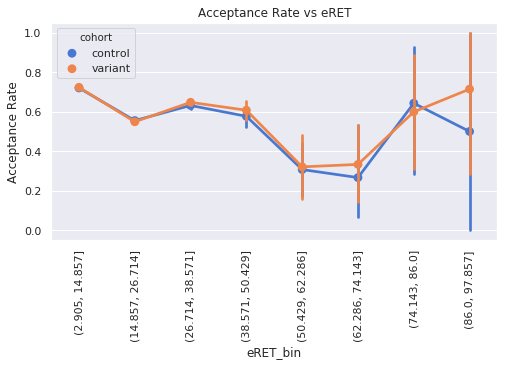

In [78]:
fig, ax = plt.subplots(figsize=(8, 4))
tmpdf = (
    processed_data
    .groupby(['cohort', 'rider_zone_id', 'experiment_date', 'eRET_bin'])
    .assignment_rejected.mean()
    .apply(lambda x: 1 - x)
    .reset_index()
)
sns.pointplot(x='eRET_bin', y='assignment_rejected', hue='cohort',
              data=tmpdf, ax=ax, alpha=0.5)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Acceptance Rate')
_ = ax.set_title('Acceptance Rate vs eRET')

# PATO 100 Projections

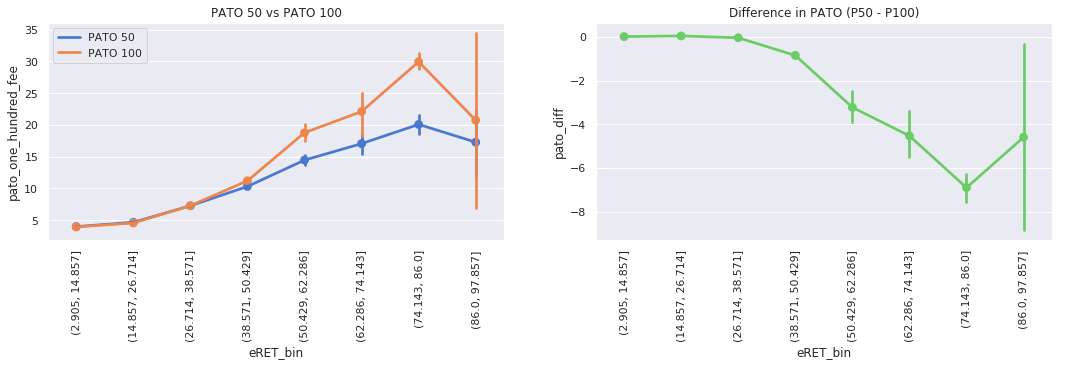

In [79]:
# pato 100
tmpdf = (
    processed_data
    [processed_data.cohort == 'variant']
    [['rider_zone_id', 'experiment_date', 'eRET_bin', 'fee_offered_without_surge',
     'pato_one_hundred_fee']]
    .pipe(lambda df: df.assign(pato_diff=(df.fee_offered_without_surge
                                          - df.pato_one_hundred_fee)))
    .groupby(['rider_zone_id', 'experiment_date', 'eRET_bin'])
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.pointplot(x='eRET_bin', y='fee_offered_without_surge', color=default_palette[0],
              data=tmpdf, ax=ax[0], alpha=0.5)
sns.pointplot(x='eRET_bin', y='pato_one_hundred_fee', color=default_palette[1],
              data=tmpdf, ax=ax[0], alpha=0.5)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('PATO 50 vs PATO 100')
ax[0].legend(handles=ax[0].lines[::tmpdf.eRET_bin.nunique() + 1],
             labels=['PATO 50', 'PATO 100'])

sns.pointplot(x='eRET_bin', y='pato_diff', color=default_palette[2],
              data=tmpdf, ax=ax[1], alpha=0.5)
ax[1].tick_params(axis='x', labelrotation=90)
_ = ax[1].set_title('Difference in PATO (P50 - P100)')

# Misc

In [25]:
# what % of time do we serve parametric as fallback
(
    raw_data
    [raw_data.cohort == 'variant']
    .pato_or_param.value_counts()
)

model_v2      1635770
parametric     130618
Name: pato_or_param, dtype: int64